In [53]:
pip install seaborn

   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import numpy as np
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import logging
import os
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(suppress=True)

In [2]:
# Memory fix
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
# Working directories
#data_dir = '/home/vita/tomo_home/project/image_dataset_grayscale_noise'
#working_dir = '/home/vita/tomo_home/project/training_grayscale_noise'
data_dir = 'C:/Users/Meter/Desktop/tomo_diplomski/python/data_rgb/'
working_dir = 'C:/Users/Meter/Desktop/tomo_diplomski/python/training'

In [4]:
# Initiate logger
logger = logging.getLogger('tensorflow')
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(message)s')

In [5]:
# Define parameters
batch_size =16
image_height = 128
image_width = 128
color_mode = 'rgb'
no_of_channels = 3
epochs = 10
#folds = 10
split_percentage = 0.25

In [6]:
#Must change after every training
training_no = 11

In [7]:
# Create directory for training
training_dir = os.path.join(working_dir, f'training_{training_no}')
if not os.path.exists(training_dir):
    os.makedirs(training_dir)
else:
    raise SystemExit("Training directory is already created!")

In [6]:
# Import dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    class_names=['both', 'crackles', 'wheezes', 'normal'],
    image_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode=color_mode)

AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 65494 files belonging to 4 classes.


In [7]:
seed_train_validation = 1 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.25

train_ds = tf.keras.utils.image_dataset_from_directory(
directory ='C:/Users/Meter/Desktop/tomo_diplomski/python/data_rgb/',
image_size = (128, 128),
validation_split = validation_split,
subset = "training",
seed = seed_train_validation,
color_mode = 'rgb',
shuffle = shuffle_value)

val_ds = tf.keras.utils.image_dataset_from_directory(
directory ='C:/Users/Meter/Desktop/tomo_diplomski/python/data_rgb/',
image_size = (128, 128),
validation_split = validation_split,
subset = "validation",
seed = seed_train_validation,
color_mode = 'rgb',
shuffle = shuffle_value)

Found 65494 files belonging to 4 classes.
Using 49121 files for training.
Found 65494 files belonging to 4 classes.
Using 16373 files for validation.


determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, and then move the two-third of them (2/3 of 30% = 20%) to a test set as follows

In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [9]:
print("Train: " + str(len(train_ds)))
print("Val: " + str(len(val_ds)))
print("Test: " + str(len(test_ds)))

Train: 1536
Val: 171
Test: 341


In [12]:

input = keras.layers.Input(shape=(image_height, image_width, no_of_channels), name="input")
x = keras.layers.Rescaling(1./255)(input)
x = keras.layers.Conv2D(32, 3, strides=(1, 3), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.1)(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Conv2D(64, 3, strides=(1, 3), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.1)(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
x = keras.layers.Dropout(0.5)(x)
hidden1 = keras.layers.Flatten()(x)

hidden1 = keras.layers.Dense(100)(hidden1)
hidden1 = keras.layers.LeakyReLU(alpha=0.1)(hidden1)
hidden1 = keras.layers.Dropout(0.5)(hidden1)

hidden2 = keras.layers.Dense(200)(hidden1)
hidden2 = keras.layers.LeakyReLU(alpha=0.1)(hidden2)
hidden2 = keras.layers.Dropout(0.5)(hidden2)

hidden3 = keras.layers.Dense(100)(hidden2)
hidden3 = keras.layers.LeakyReLU(alpha=0.3)(hidden3)
hidden3 = keras.layers.Dropout(0.5)(hidden3)

output = keras.layers.Dense(4, activation='softmax')(hidden3)

In [13]:
# Define callback - if weights don't change after 10 epochs stop training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Create net for training
net= keras.Model(input, output, name="CNN")
net.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['sparse_categorical_accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)


## Model 2

In [10]:
net = tf.keras.models.load_model('my_model2.keras')

In [91]:
net.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [92]:
history = net.fit(train_ds,  epochs=100, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10), validation_data=val_ds, shuffle=True)

Epoch 1/100


1536/1536 [==============================] - 43s 27ms/step - loss: 0.8560 - sparse_categorical_accuracy: 0.6477 - val_loss: 0.9792 - val_sparse_categorical_accuracy: 0.5997
Epoch 2/100
1536/1536 [==============================] - 42s 27ms/step - loss: 0.8642 - sparse_categorical_accuracy: 0.6430 - val_loss: 1.0121 - val_sparse_categorical_accuracy: 0.5814
Epoch 3/100
1536/1536 [==============================] - 42s 27ms/step - loss: 0.8595 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.9762 - val_sparse_categorical_accuracy: 0.5743
Epoch 4/100
1536/1536 [==============================] - 44s 28ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.6476 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.6048
Epoch 5/100
1536/1536 [==============================] - 44s 28ms/step - loss: 0.8567 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.9758 - val_sparse_categorical_accuracy: 0.5973
Epoch 6/100
1536/1536 [==============================] - 42s 28ms/step - loss: 0.8587 -

In [93]:
print(np.median(history.history['sparse_categorical_accuracy']), np.median(history.history['val_sparse_categorical_accuracy']))

0.6442662179470062 0.5977843105792999


In [94]:
print("Evaluate on test data")
results = net.evaluate(test_ds)
print("test loss, test acc:", results)

Evaluate on test data
341/341 [==============================] - 3s 8ms/step - loss: 0.9846 - sparse_categorical_accuracy: 0.5818
test loss, test acc: [0.9846464395523071, 0.5818365216255188]


341/341 [==============================] - 3s 8ms/step
Prediction accuracy: 0.4714992668621701


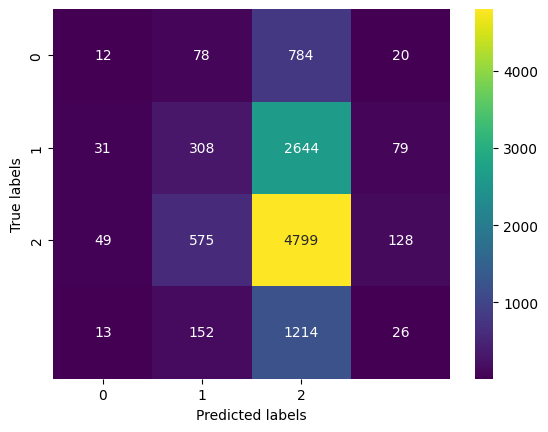

In [95]:
predictions = net.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)

true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)
print("Prediction accuracy: "+str(accuracy))

sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [96]:
net.save('my_model2.keras')

In [11]:
net.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 43, 32)       896       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 43, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 21, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 21, 32)        0         
                                                               

## Model 1

In [61]:
new_model = tf.keras.models.load_model('my_model.keras')

In [62]:
new_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 43, 32)       896       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 128, 43, 32)       0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 21, 32)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 64, 21, 32)        0         
                                                               

In [18]:
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
K.set_value(new_model.optimizer.learning_rate, 0.001)

Nastavimo trenirati taj model. Ponovo ćemo spremiti model jer će se težine u mreži promijeniti.

In [ ]:
history = new_model.fit(train_ds,  epochs=20, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10), validation_data=val_ds, shuffle=True)

In [45]:
print(np.median(history.history['sparse_categorical_accuracy']), np.median(history.history['val_sparse_categorical_accuracy']))


0.8142647743225098 0.5923823416233063


In [20]:
print("Evaluate on test data")
results = new_model.evaluate(test_ds)
print("test loss, test acc:", results)

Evaluate on test data
341/341 [==============================] - 3s 9ms/step - loss: 1.0323 - sparse_categorical_accuracy: 0.5433
test loss, test acc: [1.0323212146759033, 0.5432551503181458]


In [21]:
predictions = new_model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())
accuracy = accuracy_score(true_labels, predicted_labels)
print("Prediction accuracy: ", accuracy)

341/341 [==============================] - 3s 9ms/step
Prediction accuracy:  0.3538306451612903


In [22]:
new_model.save('my_model.keras')